In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import BayesianRidge

pd.set_option('display.max_rows', 100) # Mostra fino a 100 righe
pd.set_option('display.max_columns', 50) # Mostra fino a 50 colonne
pd.set_option('display.width', 1000) # Aumenta la larghezza massima della visualizzazione

# --- Project Constants ---
PKL_PATH = "../data/interim/"
INPUT_PKL_FILENAME = "preprocessed.pkl"

TARGET_VARIABLE = 'decision'
SEED = 37  # For reproducibility

df = pd.read_pickle(PKL_PATH + INPUT_PKL_FILENAME)
# ----------------------------------------------------

# 1. Preparazione Dati
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# --- Definizione Colonne e Preprocessing Transformers (invariato) ---
categorical_columns = ['race', 'race_o', 'field']
binary_text_columns = ['gender']
binary_numeric_columns = ['samerace']
numeric_columns = [
    col for col in X.select_dtypes(include=['int64', 'float64']).columns
    if col not in binary_numeric_columns
]

# --- Pipeline per le colonne NUMERICHE STANDARD ---
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(
        estimator=BayesianRidge(), 
        max_iter=20, 
        random_state=SEED
    )),
    ('scaler', RobustScaler())
])

# --- Pipeline per le colonne CATEGORICHE A PIÙ LIVELLI ---
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# --- Pipeline per le colonne BINARIE (la parte nuova e interessante) ---
# Creiamo un trasformatore personalizzato per mappare 'gender'
# Questo è molto più pulito e sicuro che farlo fuori dalla pipeline
class GenderMapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Usiamo .loc per evitare SettingWithCopyWarning
        X_copy = X.copy()
        gender_map = {'female': 0, 'male': 1}
        # Applichiamo la mappa. I NaN rimangono NaN.
        X_copy['gender'] = X_copy['gender'].map(gender_map)
        return X_copy

# Ora la pipeline per 'gender'
binary_text_transformer = Pipeline(steps=[
    ('mapper', GenderMapper()), # Mappa 'female'/'male' a 0/1
    ('imputer', SimpleImputer(strategy='most_frequent')) # Imputa i NaN con la moda (0 o 1)
])

# Pipeline per 'samerace' (che è già quasi a posto)
binary_numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('bin_text', binary_text_transformer, binary_text_columns),
        ('bin_num', binary_numeric_transformer, binary_numeric_columns)
    ],
    remainder='passthrough'
)

Allenamento del modello CatBoost finale sull'intero training set...
Allenamento completato.

Estrazione e visualizzazione delle Feature Importance...


C:\Users\ardui\AppData\Local\Temp\ipykernel_57072\3950812503.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


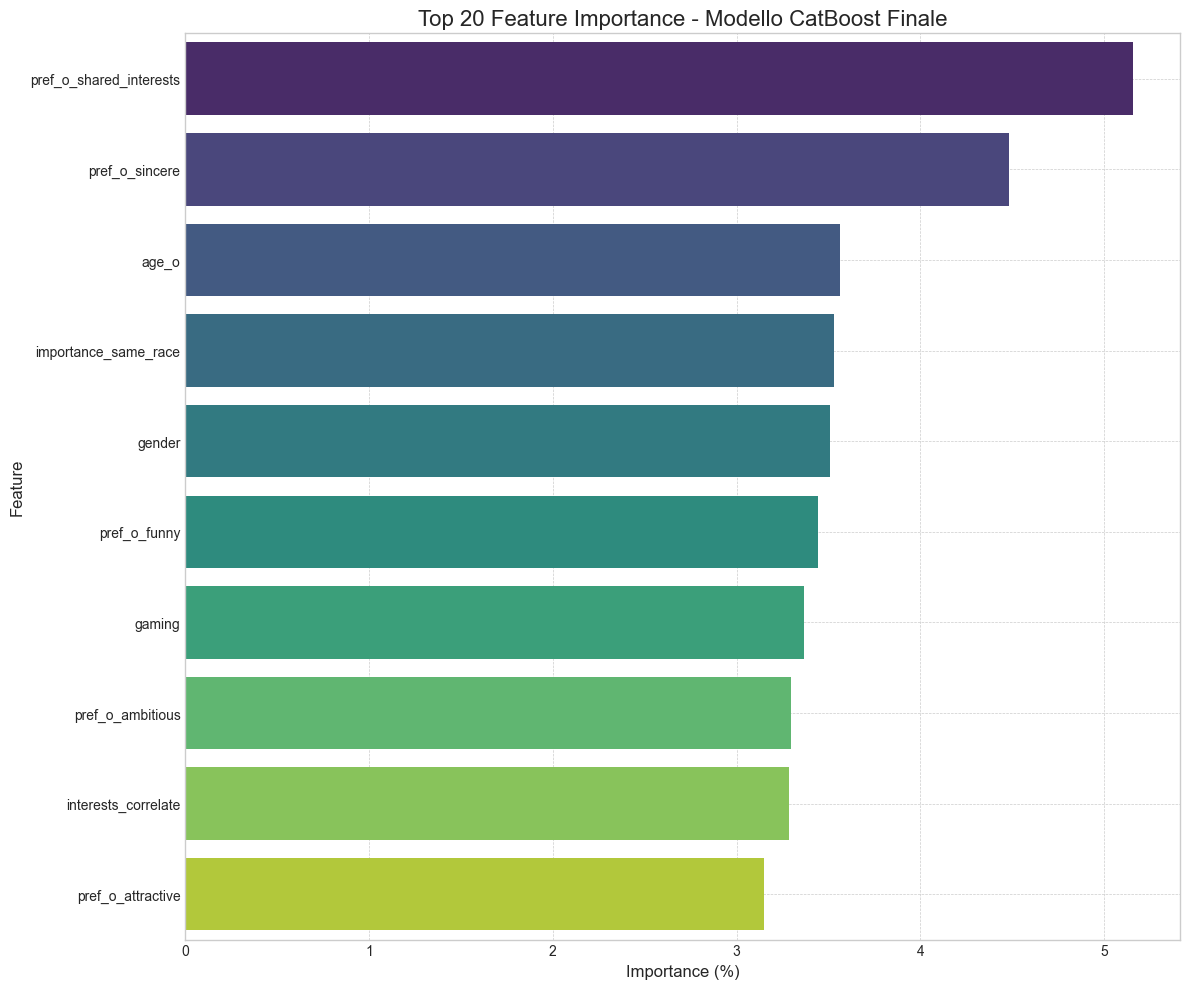

In [5]:
counts = y_train.value_counts()
scale_pos_weight_value = counts[0] / counts[1]

# Questi sono i migliori iperparametri che hai trovato per CatBoost.
# Assicurati di usare quelli esatti dal tuo ultimo run vincente.
best_params_catboost = {
    'learning_rate': 0.05,
    'depth': 6,
    'scale_pos_weight': scale_pos_weight_value, # Assicurati che questa variabile sia definita
    'subsample': 0.8,
    'iterations': 340,
    'l2_leaf_reg': 6,
    'random_strength': 1.0,
    'random_state': SEED,
    'verbose': 0
}

# Creiamo l'istanza del modello finale con i parametri migliori
final_catboost_model = CatBoostClassifier(**best_params_catboost)

# Creiamo la pipeline completa finale
# (Assicurati che 'preprocessor' sia definito correttamente come nei passi precedenti)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_catboost_model)
])


# --- 2. Allenamento del Modello Finale ---

print("Allenamento del modello CatBoost finale sull'intero training set...")
# Alleniamo la pipeline completa sui dati di training
final_pipeline.fit(X_train, y_train)
print("Allenamento completato.")


# --- 3. Estrazione e Visualizzazione delle Feature Importance ---

print("\nEstrazione e visualizzazione delle Feature Importance...")

# Per ottenere i nomi corretti delle feature, dobbiamo "guardare" dentro la pipeline.
# L'oggetto preprocessor ha trasformato le colonne originali.

# Estraiamo il trasformatore delle colonne categoriche
categorical_transformer = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']
# Estraiamo il trasformatore one-hot da quella sotto-pipeline
onehot_encoder = categorical_transformer.named_steps['onehot']

# Otteniamo i nomi delle feature create dal OneHotEncoder
# Es. 'race' diventa 'race_Asian', 'race_Black', etc.
ohe_feature_names = onehot_encoder.get_feature_names_out(categorical_columns)

# Mettiamo insieme tutti i nomi delle feature nell'ordine corretto
# L'ordine deve corrispondere a come ColumnTransformer li ha assemblati
try:
    # L'ordine è: numeriche, categoriche (one-hot), binarie-testo, binarie-numeriche
    final_feature_names = numeric_columns + list(ohe_feature_names) + binary_text_columns + binary_numeric_columns

    # Ora estraiamo le importanze dal modello allenato
    feature_importances = final_pipeline.named_steps['classifier'].get_feature_importance()

    # Creiamo un DataFrame per una facile manipolazione e visualizzazione
    importance_df = pd.DataFrame({
        'Feature': final_feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # --- Visualizzazione ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plottiamo le prime 20 feature più importanti
    top_features = importance_df.head(10)

    sns.barplot(
        x='Importance',
        y='Feature',
        data=top_features,
        palette='viridis',
        ax=ax
    )

    ax.set_title('Top 20 Feature Importance - Modello CatBoost Finale', fontsize=16)
    ax.set_xlabel('Importance (%)', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nERRORE durante l'estrazione delle feature importance: {e}")
    print("Questo può accadere se l'ordine delle colonne non è corretto o se ci sono discrepanze.")
    print("Il modello è comunque allenato e pronto per essere usato per le predizioni.")